## Вариант 14

Функция распределения дистанции до помехи: p (релеевское распределение)

Функция распределения длительности помехи: exp (экспоненциальное распределение)

Функция распределения амплитуды помехи: exp (экспоненциальное распределение)

Вероятность положительного напряжения помехи: 0.45

Длина кодовой комбинации: 12

Режим работы: r = 3 обнаруживаемых ошибок

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Класс имитационной модели

In [11]:
class SimulationModel:
    
    # Конструктор
    def __init__(self, u_threshold=1, prob_positive=0.5, num_bits=3000, message_length=15, in_signal=np.random.choice([1, 0], 3000, p=[0.4, 0.6])):
        self.u_threshold            = u_threshold      # пороговый уровень сигнала
        self.prob_positive          = prob_positive    # вероятность положительного напряжения помехи
        self.num_bits               = num_bits         # число бит
        self.message_length         = message_length   # длина кодовой комбинации
        self.in_signal              = in_signal        # входной сигнал
        self.out_signal             = []               # выходной сигнал
        self.in_out_diff            = []               # разница между входным и выходным сигналами
        self.noise                  = []               # помехи
        self.errors                 = []               # ошибки
        self.error_intervals        = [0]              # длины интервалов между ошибками (C1[i])
        self.messages_errors        = []               # число ошибок в кодовых комбинациях
        self.non_corrupt_bits       = num_bits         # число неискаженных бит (NB)
        self.corrupt_bits           = 0                # число искаженных бит (IB)
        self.non_corrupt_messages   = 0                # число неискаженных кодовых комбинаций (KDN)
        self.corrupt_messages       = 0                # число искаженных кодовых комбинаций (KDI)
    
    # Релеевское распределение
    def random_rayleigh_value(self, x, scale):
        return (scale * np.sqrt(-2*np.log(x)))
    
    # Экспоненциальное распределение
    def random_exponential_value(self, x, intensity):
        return (-np.log(x) / intensity)
    
    # Генерация помех
    def generate_noise(self):
        i = 0
        while (i < self.num_bits):
            distance = np.round(self.random_rayleigh_value(np.random.rand(), 2), 3) # дистанция до очередной помехи
            duration = np.round(self.random_exponential_value(np.random.rand(), 0.5), 3) # длительность помехи
            amplitude = np.round(self.random_exponential_value(np.random.rand(), 0.5), 3) # амплитуда помехи
            polarity = 1 if (np.random.rand() <= self.prob_positive) else -1 # полярность помехи
            
            # заполняем массив с помехами (попутно рассматриваем интервалы между ошибками)
            j = 0
            while (j < distance and len(self.noise) < self.num_bits):
                self.noise.append(0)
                self.errors.append(0)
                self.error_intervals[-1] += 1
                j += 1
                i += 1

            if (amplitude >= self.u_threshold): self.error_intervals.append(0) # Если сгенерированная помеха является ошибкой - начинаем новый интервал
                
            j = 0
            while (j < duration and len(self.noise) < self.num_bits):
                self.noise.append(amplitude * polarity)
                if (amplitude >= self.u_threshold):
                    self.errors.append(amplitude * polarity)
                else: 
                    self.errors.append(0)
                    self.error_intervals[-1] += 1
                j += 1
                i += 1
     
    # Расчет выходного сигнала с учетом ошибок
    def calculate_out_signal(self):
        for i in range(0, self.num_bits):
            if (self.in_signal[i] == 0 and self.errors[i] > 0):
                self.out_signal.append(1)
                self.in_out_diff.append(1)
            elif (self.in_signal[i] == 1 and self.errors[i] < 0):
                self.out_signal.append(0)
                self.in_out_diff.append(1)
            else:
                self.out_signal.append(self.in_signal[i])
                self.in_out_diff.append(0)
    
    # Определение числа искаженных / неискаженных бит информации           
    def bits_stats(self):
        self.corrupt_bits = np.sum(self.in_out_diff)
        self.non_corrupt_bits -= self.corrupt_bits
    
    # Определение числа искаженных / неискаженных кодовых комбинаций (+ подсчет числа ошибок в каждой из кодовых комбинаций)
    def messages_stats(self):
        for i in range(0, self.num_bits, self.message_length):
            self.messages_errors.append(0)
            errors_num = np.sum(self.in_out_diff[i : i+self.message_length])
            if ( errors_num > 0 ):
                self.corrupt_messages += 1
                self.messages_errors[-1] += errors_num
            else:
                self.non_corrupt_messages += 1
    
    # Запуск модели
    def run(self):
        self.generate_noise()
        self.calculate_out_signal()
        self.bits_stats()
        self.messages_stats()
    
    # Построение картины искажений
    def plot(self, num_steps=100):
        fig, (ax_noise, ax_in_sig, ax_out_sig, ax_diff) = plt.subplots(4, sharex=True)
        fig.set_size_inches(23, 10)
        fig.suptitle("Статистическая картина искажений", fontsize=30)

        ax_noise.bar(range(0, num_steps), self.noise[:num_steps], width = 1, fill=False, edgecolor="black", linewidth=3)
        ax_noise.plot(range(0, num_steps), np.full(num_steps, self.u_threshold), color="red", linewidth=2, linestyle="dashed")
        ax_noise.plot(range(0, num_steps), np.full(num_steps, -self.u_threshold), color="red", linewidth=2, linestyle="dashed")
        ax_noise.set_ylim([-1.5, 1.5])
        ax_noise.set_title('Помехи', loc="left")

        ax_in_sig.bar(range(0, num_steps), self.in_signal[:num_steps], width = 1, fill=False, edgecolor="blue", linewidth=3)
        ax_in_sig.set_title('Входной сигнал', loc="left")

        ax_out_sig.bar(range(0, num_steps), self.out_signal[:num_steps], width = 1, fill=False, edgecolor="green", linewidth=3)
        ax_out_sig.set_title('Выходной сигнал', loc="left")

        ax_diff.bar(range(0, num_steps), self.in_out_diff[:num_steps], width = 1, fill=False, edgecolor="red", linewidth=3)
        ax_diff.set_title('Ошибки', loc="left")

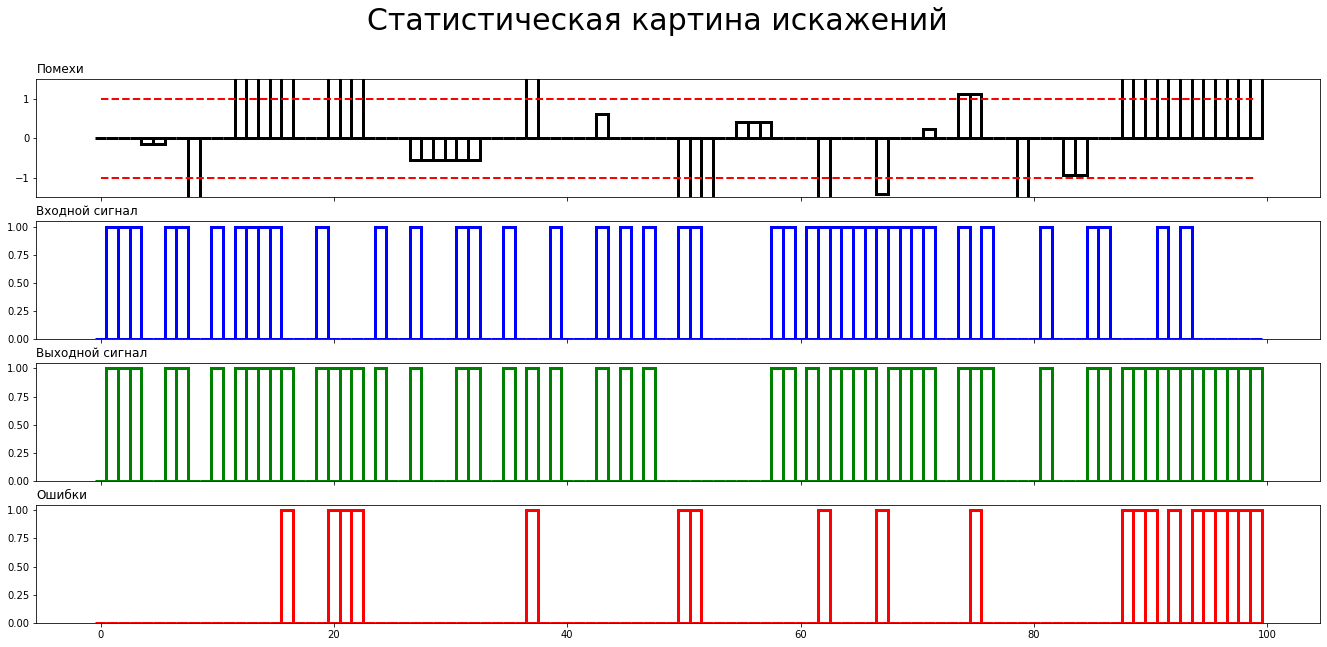

In [12]:
model = SimulationModel(u_threshold=1, prob_positive=0.45, num_bits=3000, message_length=12, in_signal=np.random.choice([1, 0], 3000, p=[0.4, 0.6]))
model.run()
model.plot(num_steps=100)

In [13]:
u_thresholds = [0.5, 1, 1.5, 2, 2.5]
r = 3
m = 8
data = {'U_пор': [],
        '№ опыта': [],
        'NB': [],
        'IB': [],
        'KDN': [],
        'KDI': [],
        'P_ош': [],
        'P_g': [],
        'P_(g,n)': [],
        'P_сд': [],
        'P_нд': []
       }

In [14]:
for u_value in u_thresholds:
    for i in range(1, 3):
        model = SimulationModel(u_threshold=u_value, prob_positive=0.45, num_bits=3000, message_length=12, in_signal=np.random.choice([1, 0], 3000, p=[0.4, 0.6]))
        model.run()
        
        data['U_пор'].append(u_value)
        data['№ опыта'].append(i)
        data['NB'].append(model.non_corrupt_bits)
        data['IB'].append(model.corrupt_bits)
        data['KDN'].append(model.non_corrupt_messages)
        data['KDI'].append(model.corrupt_messages)
        
        prob_err = model.corrupt_bits / model.num_bits
        data['P_ош'].append(prob_err)
        
        prob_fix_pos_err = (prob_err**r) * ((1 - prob_err)**(model.message_length - r))
        data['P_g'].append(prob_fix_pos_err)
        
        prob_g_err = np.math.factorial(model.message_length) / (np.math.factorial(model.message_length - r) * np.math.factorial(r)) * (prob_err**r) * ((1 - prob_err)**(model.message_length - r))
        data['P_(g,n)'].append(prob_g_err)
        
        prob_sd = model.message_length * prob_err
        data['P_сд'].append(prob_sd)
        
        prob_nd = (1 / (2**(model.message_length - m))) * (np.math.factorial(model.message_length) / (np.math.factorial(r + 1) * np.math.factorial(model.message_length - r + 1))) * (prob_err**(r + 1))
        data['P_нд'].append(prob_nd)

In [15]:
df = pd.DataFrame(data)
df

,U_пор,№ опыта,NB,IB,KDN,KDI,P_ош,P_g,"P_(g,n)",P_сд,P_нд
0,0.5,1,2519,481,50,200,0.160333,0.000855,0.188129,1.924,0.000227
1,0.5,2,2504,496,43,207,0.165333,0.000889,0.195489,1.984,0.000257
2,1.0,1,2588,412,61,189,0.137333,0.000685,0.150778,1.648,0.000122
3,1.0,2,2583,417,62,188,0.139000,0.000698,0.153637,1.668,0.000128
4,1.5,1,2676,324,100,150,0.108000,0.000450,0.099078,1.296,0.000047
5,1.5,2,2704,296,101,149,0.098667,0.000377,0.082967,1.184,0.000033
6,2.0,1,2730,270,124,126,0.090000,0.000312,0.068631,1.080,0.000023
7,2.0,2,2747,253,135,115,0.084333,0.000271,0.059711,1.012,0.000017
8,2.5,1,2825,175,155,95,0.058333,0.000116,0.025424,0.700,0.000004
9,2.5,2,2804,196,149,101,0.065333,0.000152,0.033399,0.784,0.000006


In [16]:
data = {'Столбец': ['U_пор', 'NB', 'IB', 'KDN', 'KDI', 'P_ош', 'P_g', 'P_(g,n)', 'P_сд', 'P_нд'],
        'Расшифровка': ['Пороговое напряжение', 'Количество неискаженных бит информации', 'Количество искаженных бит информации', 'Количество неискаженных кодовых комбинаций', 'Количество искаженных кодовых комбинаций', 'Вероятность искажения одиночного символа кода', 'Вероятность появления g ошибок на фиксированных позициях кода', 'Вероятность возникновения g на длине кода', 'Вероятность стирания при декодировании', 'Вероятность неправильного декодирования']}

In [17]:
pd.options.display.max_colwidth = 150

In [18]:
df = pd.DataFrame(data)
df.set_index('Столбец')
df

,Столбец,Расшифровка
0,U_пор,Пороговое напряжение
1,NB,Количество неискаженных бит информации
2,IB,Количество искаженных бит информации
3,KDN,Количество неискаженных кодовых комбинаций
4,KDI,Количество искаженных кодовых комбинаций
5,P_ош,Вероятность искажения одиночного символа кода
6,P_g,Вероятность появления g ошибок на фиксированных позициях кода
7,"P_(g,n)",Вероятность возникновения g на длине кода
8,P_сд,Вероятность стирания при декодировании
9,P_нд,Вероятность неправильного декодирования
